# Library

In [1]:
%cd ~/github/liz.9.11.19_GMVLE/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

from utils.utils import read_vcf

/Users/maartenbiolizard/GitHub/liz.9.11.19_GMVLE


# Global variables

In [2]:
PATH_RAW = "data/raw/"
PATH_INTERIM = "data/interim/"
PATH_PROCESSED = "data/processed/"
PATH_CONFIDENT_ROWS = "data/raw/HG003_GRCh38_1_22_v4.2.1_benchmark_noinconsistent.bed"

DIR_VCFEVAL = "data/vcfeval"

VC_DATA_NAME = "HG003_NA24149_Ashkenazim_father.trim"
BENCHMARK = "HG003_GRCh38_1_22_v4.2.1_benchmark"

CALLERS = ["dv", "fb", "oc", "st"]  # DeepVariant, FreeBayes, Octopus, Strelka2

CONF = {
    "dv": {"y": "FILTER", "call": "PASS"},
    "fb": {"y": "ALT", "call": "notna"},
    "oc": {"y": "FILTER", "call": "PASS"},
    "st": {"y": "FILTER", "call": "PASS"},
    "BM": {"y": "FILTER", "call": "PASS"},
    "keys": ["CHROM", "POS"],
    "features": ["QUAL", "DP"],
}

DTYPE = {
    "CHROM": pd.Int64Dtype(),
    "POS": int,
    "ID": str,
    "REF": str,
    "ALT": str,
    "QUAL": float,
    "FILTER": str,
    "INFO": str,
    "FORMAT": str,
    VC_DATA_NAME: str,
    "HG003": str,
    "DP": pd.Int64Dtype(),
    "REF_same": "boolean",
    "DP_same": "boolean",
    "REF_BM": str,
    "ALT_BM": str,
    "FILTER_BM": str,
    "CONFIDENCE": bool,
    "CONFIDENCE_start": int,
    "CONFIDENCE_end": int,
}

# Load & standardise the data

In [3]:
def load_vcf_to_csv(callers=CALLERS, benchmark=BENCHMARK):
    for caller in callers:
        if not os.path.exists(PATH_INTERIM + caller + ".csv"):
            file_name = PATH_RAW + VC_DATA_NAME + "." + caller + ".vcf"
            data = read_vcf(file_name)
            data.to_csv(PATH_INTERIM + caller + ".csv", index=False)
            print(f"Saved {caller}.csv")
        else:
            print(f"{caller}.csv already exists")

    if not os.path.exists(PATH_INTERIM + benchmark + ".csv"):
        file_name = PATH_RAW + benchmark + ".vcf"
        benchmark_df = read_vcf(file_name)
        benchmark_df.to_csv(PATH_INTERIM + benchmark + ".csv", index=False)
        print(f"Saved {benchmark}")
    else:
        print(f"{benchmark} already exists")


load_vcf_to_csv()

dv.csv already exists
fb.csv already exists
oc.csv already exists
st.csv already exists
HG003_GRCh38_1_22_v4.2.1_benchmark already exists


In [4]:
def get_values_from_format(
    data: pd.DataFrame, format_column: str = "FORMAT", value_column: str = VC_DATA_NAME
) -> pd.DataFrame:

    dict_error = {}

    # Assume that the FORMAT column is a string with the values separated by ":", and is the same for all rows
    # check if FORMAT column is unique
    if data[format_column].nunique() == 1:
        print("FORMAT column is unique")

        value_names = data[format_column].iloc[0].split(":")

        # split the value column by ":", and convert it to separate columns
        values = data[value_column].str.split(":", expand=True)
        values.columns = value_names

        # drop the original value column and concatenate the new columns
        data = data.drop(value_column, axis=1).drop(format_column, axis=1)
        data_new = pd.concat([data, values], axis=1).copy()

    else:
        print("FORMAT column is not unique")

        # convert the format_column and value_column to a dict per row
        format_dict = {}

        for row in data.iterrows():

            # get row index and values
            index = row[0]

            values = row[1][value_column].split(":")
            cols = row[1]["FORMAT"].split(":")

            if len(values) != len(cols):
                # Different lengths at this row
                if row[1]["CHROM"] not in dict_error:
                    dict_error[row[1]["CHROM"]] = [row[1]["POS"]]
                else:
                    dict_error[row[1]["CHROM"]].append(row[1]["POS"])

                # add empty values to match the length of cols
                values += [np.nan] * (len(cols) - len(values))

            format_dict[index] = dict(zip(cols, values))

        # drop the original value column and concatenate the new columns
        data = data.drop(value_column, axis=1).drop(format_column, axis=1)
        data_new = data.merge(
            pd.DataFrame(format_dict).T, left_index=True, right_index=True
        ).copy()

        print("Different lenght at CHROM: positions\n", dict_error)

    return data_new

## Merged variant calls

In [5]:
def process_vcf_data(callers=CALLERS, benchmark=BENCHMARK, dtype=DTYPE):

    cols_to_keep = [
        "CHROM",
        "POS",
        "REF",
        "ALT",
        "QUAL",
        "FILTER",  # original columns
        "DP",  # "GT", "GQ" columns from FORMAT
    ]

    for caller in callers:

        if not os.path.exists(PATH_PROCESSED + caller + ".csv"):
            print(f"Processing {caller}.csv")
            data = pd.read_csv(
                PATH_INTERIM + caller + ".csv", dtype=dtype, na_values="."
            )
            data_new = get_values_from_format(data)[cols_to_keep]
            data_new.to_csv(PATH_PROCESSED + caller + ".csv", index=False)
            display(data_new.head())

        else:
            print(f"{caller}.csv already processed")

    if not os.path.exists(PATH_PROCESSED + benchmark + ".csv"):
        print(f"Processing {benchmark}.csv")
        data = pd.read_csv(
            PATH_INTERIM + benchmark + ".csv", dtype=dtype, na_values="."
        )
        data_new = get_values_from_format(data, value_column="HG003")[cols_to_keep]

        # remove "chr" from CHROM column to match the other data
        data_new["CHROM"] = data_new["CHROM"].str.replace("chr", "")

        data_new.to_csv(PATH_PROCESSED + benchmark + ".csv", index=False)
        display(data_new.head())

    else:
        print(f"{benchmark}.csv already processed")


process_vcf_data()

dv.csv already processed
fb.csv already processed
oc.csv already processed
st.csv already processed
HG003_GRCh38_1_22_v4.2.1_benchmark.csv already processed


In [6]:
def duplicates_resolve(
    df: pd.DataFrame, keys: list = CONF["keys"], feature_sort: list = [], name=None
) -> pd.DataFrame:
    # Check for duplicates
    dupl = df.duplicated(subset=keys)
    if dupl.sum() > 0:
        # sort by features and keep the row with the highest value for the feature_sort columns
        if len(feature_sort) > 0:
            df = (
                df.sort_values(by=feature_sort, ascending=False)
                .drop_duplicates(subset=keys)
                .copy()
            )
            print(f"Removed {dupl.sum()} duplicates" + (f" in {name}" if name else ""))
        else:
            print(
                f"Found {dupl.sum()} duplicates"
                + (f" in {name}" if name else "")
                + ", but no feature_sort columns given"
            )
    else:
        print("No duplicates found")

    return df

In [7]:
# Merge the dataframes on CHROM and POS
# Columns that are required to be the same in all dataframes: REF, DP
# Columns that are specific to the caller: ALT, QUAL, FILTER


def merge_dataframes(
    callers=CALLERS, on=["CHROM", "POS"], same_col=["REF", "DP"], dtype=DTYPE
) -> pd.DataFrame:

    file_name = PATH_PROCESSED + "merged.csv"
    if not os.path.exists(file_name):
        print("Merging dataframes")

        dataframes = []
        dtype.update({"CHROM": str})  # necessary for the callers to be merged

        # check for duplicates in the on columns and keep the row with the highest QUAL
        for caller in callers:
            df = pd.read_csv(PATH_PROCESSED + caller + ".csv", dtype=dtype)
            dupl = df.duplicated(subset=on)
            if dupl.sum() > 0:
                df = df.sort_values("QUAL", ascending=False).drop_duplicates(subset=on)
                print(f"Dropped {dupl.sum()} duplicates in {caller}.csv")

            dataframes.append(df)

        # Create the merged dataframe
        for caller, df in zip(callers, dataframes):
            df.columns = [
                col + f"_{caller}" if col not in on else col for col in df.columns
            ]

        df_merged = reduce(
            lambda left, right: pd.merge(left, right, on=on, how="outer"), dataframes
        )

        # Check if the data in the same columns is the same when it's not NaN

        for col in same_col:
            df_merged[f"{col}_same"] = df_merged[
                [f"{col}_{caller}" for caller in callers]
            ].apply(lambda x: len(set(x.dropna())) == 1, axis=1)

        # Save the dataframe
        df_merged.to_csv(file_name, index=False)

    else:
        print("Merged dataframe already exists")
        df_merged = pd.read_csv(file_name)

    # check if the merged dataframe has duplicates
    dupl = df_merged.duplicated(subset=on)
    if dupl.sum() > 0:
        print("Duplicates in merged dataframe: ", dupl.sum())
    else:
        print("No duplicates in merged dataframe")

    return df_merged

In [8]:
df_merged = merge_dataframes()
df_merged.head()

Merged dataframe already exists


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_6631/2422697676.py:49: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv(file_name)


No duplicates in merged dataframe


,CHROM,POS,REF_dv,ALT_dv,QUAL_dv,FILTER_dv,DP_dv,REF_fb,ALT_fb,QUAL_fb,...,QUAL_oc,FILTER_oc,DP_oc,REF_st,ALT_st,QUAL_st,FILTER_st,DP_st,REF_same,DP_same
0,1,10103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,T,A,0.0,LowGQX;NoPassedVariantGTs,12.0,True,True
1,1,10105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,A,C,0.0,LowGQX;NoPassedVariantGTs,16.0,True,True
2,1,10120,T,C,0.0,RefCall,127.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
3,1,10126,T,C,0.0,RefCall,116.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
4,1,10132,T,C,0.0,RefCall,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True


## Merged variant calls + benchmark

In [9]:
def merge_benchmark(
    df_benchmark, df_merged, on=["CHROM", "POS"], dtype=DTYPE
) -> pd.DataFrame:

    file_name = PATH_PROCESSED + "merged_benchmark.csv"
    if not os.path.exists(file_name):
        print("Merging benchmark")
        df_benchmark.columns = [
            col + "_BM" if col not in ["CHROM", "POS"] else col
            for col in df_benchmark.columns
        ]

        # Select only the chromosomes that are in the benchmark
        chromosomes = df_benchmark["CHROM"].unique()
        df_merged = df_merged[df_merged["CHROM"].isin(chromosomes)]

        df_merged = pd.merge(df_merged, df_benchmark, on=on, how="outer")
        df_merged.to_csv(file_name, index=False)

    else:
        print("Merged benchmark already exists")
        df_merged = pd.read_csv(file_name, dtype=dtype)

    # print the number of rows per chromosome
    # print("Number of rows per chromosome")
    # display(df_merged["CHROM"].value_counts().sort_index())

    # check if the merged dataframe has duplicates
    duplicates_resolve(df_merged, on, name="merged_benchmark")

    return df_merged


df_benchmark = pd.read_csv(PATH_PROCESSED + BENCHMARK + ".csv")
df_merged_BM = merge_benchmark(df_benchmark, df_merged)
df_merged_BM.head()

Merged benchmark already exists
No duplicates found


,CHROM,POS,REF_dv,ALT_dv,QUAL_dv,FILTER_dv,DP_dv,REF_fb,ALT_fb,QUAL_fb,...,QUAL_st,FILTER_st,DP_st,REF_same,DP_same,REF_BM,ALT_BM,QUAL_BM,FILTER_BM,DP_BM
0,1,10103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,LowGQX;NoPassedVariantGTs,12.0,True,True,NaN,NaN,NaN,NaN,NaN
1,1,10105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,LowGQX;NoPassedVariantGTs,16.0,True,True,NaN,NaN,NaN,NaN,NaN
2,1,10120,T,C,0.0,RefCall,127.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN
3,1,10126,T,C,0.0,RefCall,116.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN
4,1,10132,T,C,0.0,RefCall,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN


## Merged variant calls + benchmark: High confidence

### Confidence regions

In [10]:
# chromStart is inclusive (first = 0), chromEnd is exclusive (https://en.wikipedia.org/wiki/BED_(file_format))


def read_conf_regions(file_name: str) -> pd.DataFrame:

    confidence_regions = pd.read_csv(
        file_name, sep="\t", header=None, names=["CHROM", "START", "END"]
    )
    confidence_regions["CHROM"] = confidence_regions["CHROM"].str.replace("chr", "")

    # convert chrom to int
    confidence_regions["CHROM"] = confidence_regions["CHROM"].astype(int)

    return confidence_regions

In [11]:
# import library for fast interval overlap
# NCLS: https://github.com/pyranges/ncls
from ncls import NCLS


def select_confident_regions(df, confidence_regions, name, dtype=DTYPE) -> pd.DataFrame:

    file_name = PATH_PROCESSED + f"{name}.csv"
    file_name_ann = PATH_PROCESSED + f"{name}_annotated.csv"

    if not os.path.exists(file_name):

        print(f"Selecting confident regions for {name}")
        list_df_chr = []

        confidence_regions["CHROM"] = confidence_regions["CHROM"].astype(str)

        for chr in confidence_regions["CHROM"].unique():
            confidence_chr = confidence_regions[confidence_regions["CHROM"] == chr]
            ncls = NCLS(
                confidence_chr["START"].values,
                confidence_chr["END"].values,
                confidence_chr.index.values,
            )

            df_chr = df[df["CHROM"] == chr].copy()

            p_ix, i_ix = ncls.all_overlaps_both(
                df_chr["POS"].values, df_chr["POS"].values + 1, df_chr.index.values
            )
            i = confidence_chr.reindex(i_ix).reset_index(drop=True)

            # intitialize CONFIDENCE columns with False
            df_chr["CONFIDENCE"] = False
            df_chr["CONFIDENCE_start"] = np.nan
            df_chr["CONFIDENCE_end"] = np.nan

            df_chr.loc[p_ix, "CONFIDENCE"] = True
            df_chr.loc[p_ix, "CONFIDENCE_start"] = i["START"].values
            df_chr.loc[p_ix, "CONFIDENCE_end"] = i["END"].values

            df_chr.loc[p_ix, "CONFIDENCE_start"] = df_chr.loc[
                p_ix, "CONFIDENCE_start"
            ].astype(int)
            df_chr.loc[p_ix, "CONFIDENCE_end"] = df_chr.loc[
                p_ix, "CONFIDENCE_end"
            ].astype(int)

            list_df_chr.append(df_chr)

        df_conf_ann = pd.concat(list_df_chr)
        df_conf = df_conf_ann[df_conf_ann["CONFIDENCE"]]

        display(df_conf_ann.head())

        # check for duplicates
        duplicates_resolve(df_conf_ann, keys=["CHROM", "POS"], name="df_conf_annotated")

        # Save the dataframes
        df_conf_ann.to_csv(file_name_ann, index=False)
        df_conf.to_csv(file_name, index=False)

    else:
        print(f"{file_name} already exists")
        df_conf = pd.read_csv(file_name, dtype=dtype)

    # check for duplicates
    duplicates_resolve(df_conf, keys=["CHROM", "POS"], name="df_conf")

    return df_conf

In [12]:
confidence_regions = read_conf_regions(PATH_CONFIDENT_ROWS)
df_merged_BM = merge_benchmark(df_benchmark, df_merged)

df_merged_BM_confident = select_confident_regions(
    df_merged_BM, confidence_regions, name="merged_benchmark_confident"
)
df_merged_BM_confident.head()

Merged benchmark already exists
No duplicates found
data/processed/merged_benchmark_confident.csv already exists
No duplicates found


,CHROM,POS,REF_dv,ALT_dv,QUAL_dv,FILTER_dv,DP_dv,REF_fb,ALT_fb,QUAL_fb,...,REF_same,DP_same,REF_BM,ALT_BM,QUAL_BM,FILTER_BM,DP_BM,CONFIDENCE,CONFIDENCE_start,CONFIDENCE_end
0,1,601544,G,A,0.4,RefCall,42.0,G,A,31.6346,...,True,False,NaN,NaN,NaN,NaN,NaN,True,601537,601963
1,1,601606,G,T,0.1,RefCall,42.0,NaN,NaN,NaN,...,True,False,NaN,NaN,NaN,NaN,NaN,True,601537,601963
2,1,601673,G,A,0.1,RefCall,46.0,NaN,NaN,NaN,...,True,True,NaN,NaN,NaN,NaN,NaN,True,601537,601963
3,1,601811,C,G,0.4,RefCall,41.0,C,G,65.2423,...,True,False,NaN,NaN,NaN,NaN,NaN,True,601537,601963
4,1,601890,C,T,1.2,RefCall,33.0,C,T,140.8790,...,True,False,NaN,NaN,NaN,NaN,NaN,True,601537,601963


## Metric definitions

In [13]:
def label_caller_data(
    df_merged_BM,
    conf=CONF,
    callers=CALLERS,
    benchmark_abbr="BM",
    how="all",
    features=[],
    BM_features=[],
) -> pd.DataFrame:

    assert type(callers) == list, "callers must be a list"

    methods = callers + [benchmark_abbr]

    callers_cols = [f"{conf[method]['y']}_{method}" for method in callers]
    methods_cols = [f"{conf[method]['y']}_{method}" for method in methods]
    features_cols = [
        f"{feature}_{caller}" for feature in features for caller in callers
    ] + [f"{feature}_{benchmark_abbr}" for feature in BM_features]

    df_call = df_merged_BM.copy()[
        conf["keys"] + methods_cols + features_cols
    ].set_index(conf["keys"])

    # drop rows with nan values in all columns
    # df_call.dropna(axis = 0, how="all", inplace=True, subset=methods_cols)

    # assign the boolean labels to the data based on the call configuration
    for method in methods:
        y = conf[method]["y"]
        call = conf[method]["call"]

        if call == "notna":
            df_call[f"{y}_{method}"] = df_call[f"{y}_{method}"].notna()
        elif call == "PASS":
            df_call[f"{y}_{method}"] = df_call[f"{y}_{method}"] == "PASS"
        else:
            print("Invalid call:", call)

    # rename prediction to y_hat: if there are multiple callers, create a consensus column
    if how == "all":
        df_call["y_hat"] = df_call[callers_cols].all(axis=1)
    elif how == "majority":
        df_call["y_hat"] = df_call[callers_cols].sum(axis=1) > len(callers) / 2
    elif how == "any":
        df_call["y_hat"] = df_call[callers_cols].any(axis=1)
    elif how == "per_caller":
        for caller in callers:
            df_call[f"y_hat_{caller}"] = df_call[f"{conf[caller]['y']}_{caller}"]

    # rename the benchmark column to y
    df_call["y"] = df_call[f"{conf[benchmark_abbr]['y']}_{benchmark_abbr}"]

    if how == "per_caller":
        df_call = df_call[
            [f"y_hat_{caller}" for caller in callers] + ["y"] + features_cols
        ]

    else:
        # keep only the benchmark column (true call) and the predicted column (y_hat)
        df_call = df_call[["y", "y_hat"] + features_cols]

    return df_call


def calculate_performance(
    df_call, callers: list, dir_path=None, true_label: str = "y", pred: str = "y_hat"
):

    print(f"Calculating performance metrics for {callers}")

    caller_bool = df_call[pred]
    benchmark_bool = df_call[true_label]

    # True Positives (TP)
    TP = caller_bool & benchmark_bool

    # False Positives (FP)
    FP = caller_bool & ~benchmark_bool

    # False Negatives (FN)
    FN = ~caller_bool & benchmark_bool

    # True Negatives (TN) are not applicable: the benchmark only contains the positive cases

    if dir_path is not None:
        performance_path = os.path.join(dir_path, f"performance.csv")

        # save the TP, FP, FN, of the dataframe
        df_call["TP"] = TP
        df_call["FP"] = FP
        df_call["FN"] = FN

        df_call.to_csv(performance_path, index=False)
        print(f"Saved performance metrics to {performance_path}")

    # Performance metrics
    TP_count = TP.sum()
    FP_count = FP.sum()
    FN_count = FN.sum()

    precision = TP_count / (TP_count + FP_count)
    recall = TP_count / (FN_count + TP_count)
    F1 = 2 * precision * recall / (precision + recall)

    TP_baseline = benchmark_bool.sum()

    # create a dictionary with the performance metrics

    performance = {
        "True-pos-baseline": TP_baseline,
        "True-pos-call": TP_count,
        "False-pos": FP_count,
        "False-neg": FN_count,
        "Precision": round(precision, 4),
        "Sensitivity": round(recall, 4),
        "F-measure": round(F1, 4),
    }

    return performance

------------------------------------------------------------------------------------------------

# Perfomance metrics

In [51]:
from collections import defaultdict


def get_custom_performance(df_name, conf, callers: list, index=None):
    id_dict = {"DATA": "None", "CALLER": "None", "METHOD": "None", "METRICS": "custom"}

    list_of_dfs = []

    df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)

    for caller in callers:
        id = id_dict.copy()
        id.update({"CALLER": caller})

        df_call = label_caller_data(df_VC_BM, conf, [caller])

        if index is not None:
            if "confident" in df_name:
                id.update({"DATA": "selection_confident"})

            else:
                id.update({"DATA": "selection"})

            print(f"Selecting based on index: {len(index)} / {len(df_call)}")
            performance = calculate_performance(
                df_call.loc[df_call.index.isin(index)], [caller]
            )

        else:
            if "confident" in df_name:
                id.update({"DATA": "confident"})

            else:
                id.update({"DATA": "all"})

            performance = calculate_performance(df_call, [caller])

        multi_id = pd.MultiIndex.from_tuples([tuple(id.values())], names=id.keys())

        # add performance metrics as a df row to the table
        list_of_dfs.append(pd.DataFrame(performance, index=multi_id))

    for how in ["all", "majority", "any"]:
        id = id_dict.copy()
        id.update({"CALLER": ", ".join(callers)})
        id.update({"METHOD": how})

        df_call = label_caller_data(df_VC_BM, conf, callers, how=how)

        if index is not None:
            if "confident" in df_name:
                id.update({"DATA": "selection_confident"})

            else:
                id.update({"DATA": "selection"})

            print(f"Selecting based on index: {len(index)} / {len(df_call)}")
            performance = calculate_performance(
                df_call.loc[df_call.index.isin(index)], callers
            )

        else:
            if "confident" in df_name:
                id.update({"DATA": "confident"})
                performance = calculate_performance(df_call, callers)

            else:
                id.update({"DATA": "all"})
                performance = calculate_performance(df_call, callers)

        multi_id = pd.MultiIndex.from_tuples([tuple(id.values())], names=id.keys())

        # add performance metrics as a df row to the table
        list_of_dfs.append(pd.DataFrame(performance, index=multi_id))

    # create a table with the performance metrics
    df_performance = pd.concat(list_of_dfs, axis=0)

    return df_performance


def get_vcfeval_performance(callers: list, experiment: str, DIR_VCFEVAL: str):

    id_dict = {"DATA": "None", "CALLER": "None", "METHOD": "None", "METRICS": "vcfeval"}

    if "noinconsistent" in experiment:
        id_dict["DATA"] = "confident"
    else:
        id_dict["DATA"] = "all"

    list_of_dfs = []

    for caller in callers:
        id = id_dict.copy()
        id.update({"CALLER": caller})

        # get the summary file
        file_name = f"{DIR_VCFEVAL}/vcfeval_{caller}_{experiment}/summary.txt"

        # print the summary
        with open(file_name, "r") as file:
            lines = file.readlines()

            # drop line with '---'
            lines = [line for line in lines if not line.startswith("---")]
            print(f"Summary for {caller}")

            # put lines in a table
            table = [line.split() for line in lines]
            df = pd.DataFrame(table[1:], columns=table[0])

            # keep only threshold == None
            df = df[df["Threshold"] == "None"]

            multi_id = pd.MultiIndex.from_tuples([tuple(id.values())], names=id.keys())
            df.index = multi_id

            list_of_dfs.append(df)

    # create a table with the performance metrics
    df_performance = pd.concat(list_of_dfs, axis=0)

    return df_performance


def create_performance_table(
    df_name,
    experiment: str,
    index=None,
    conf=CONF,
    callers=CALLERS,
    DIR_VCFEVAL=DIR_VCFEVAL,
):

    # If there is an index specified, omit the vcfeval performance, because it's based on all the data
    # Table index should be:
    # DATA: all/confident;
    # CALLER: st, oc, fb, dv;
    # METHOD: None, all, majority, any, XGB, RF;
    # METRICS: vcfeval, custom]

    if index is not None:

        df_custom_performance = get_custom_performance(df_name, conf, callers, index)
        df_performance = df_custom_performance

    else:
        df_custom_performance = get_custom_performance(df_name, conf, callers)
        df_vcfeval_performance = get_vcfeval_performance(
            callers, experiment, DIR_VCFEVAL
        )

        # concat
        df_performance = pd.concat([df_custom_performance, df_vcfeval_performance])

    return df_performance

In [52]:
df_performance_list = []

for experiment, df_name, selection in zip(
    ["withoutseq_qual", "noinconsistent_withoutseq_qual"],
    ["merged_benchmark", "merged_benchmark_confident"],
    ["ALL DATA", "ONLY CONFIDENT REGIONS"],
):

    print(f"Performance for {selection}")

    df_performance = create_performance_table(df_name, experiment)
    df_performance_list.append(df_performance)

caller_order = ["dv", "fb", "oc", "st", "dv, fb, oc, st"]
df_performance = pd.concat(df_performance_list).reindex(caller_order, level="CALLER")
df_performance

Performance for ALL DATA
Calculating performance metrics for ['dv']
Calculating performance metrics for ['fb']
Calculating performance metrics for ['oc']
Calculating performance metrics for ['st']
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']


KeyboardInterrupt: 

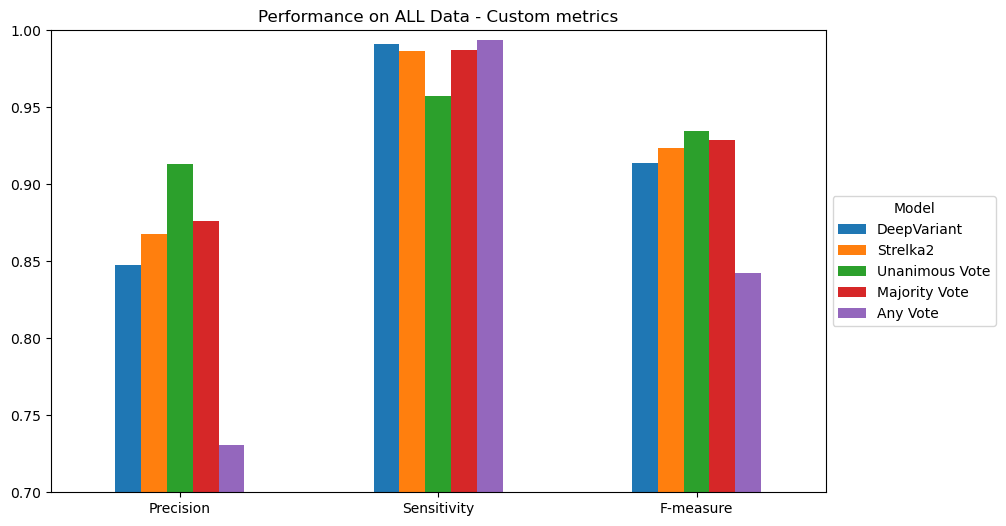

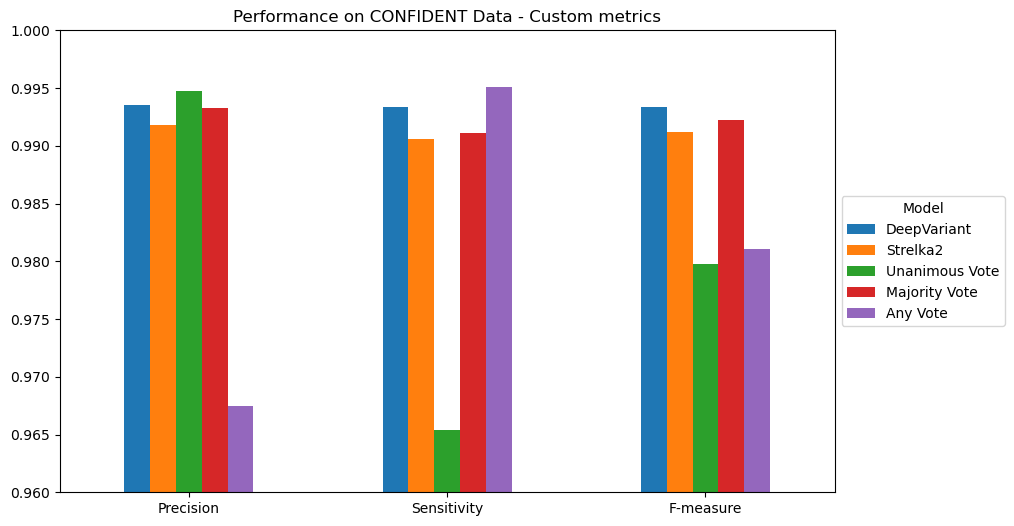

In [ ]:
for data_sel, y_low in zip(["all", "confident"], [0.70, 0.96]):

    temp = df_performance.loc[
        (data_sel, slice(None), slice(None), "custom"),
        ["Precision", "Sensitivity", "F-measure"],
    ].astype(float)

    # drop Octopus and FreeBayes

    temp = temp.drop(["oc", "fb"], level="CALLER")

    # drop DATA and METRICS columns
    temp = temp.droplevel(["DATA", "METRICS"], axis=0).transpose()

    temp.astype(float).plot(
        kind="bar",
        title=f"Performance on {data_sel.upper()} Data - Custom metrics",
        figsize=(10, 6),
    )

    # rename legend labels
    plt.legend(
        title="Model",
        labels=[
            "DeepVariant",
            "Strelka2",
            "Unanimous Vote",
            "Majority Vote",
            "Any Vote",
        ],
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )
    plt.ylim(y_low, 1)

    # turn x lables 45 degrees
    plt.xticks(rotation=0)

# ML Classifiers

## Load the data

In [15]:
def get_X_y(
    df_VC_BM, conf=CONF, callers=CALLERS, how="per_caller", features=["QUAL", "DP"]
):

    df_call = label_caller_data(
        df_VC_BM, conf, callers=callers, how=how, features=features
    )

    y = df_call["y"]
    X = df_call.drop("y", axis=1)

    return X, y

## Split the data into training and testing sets

In [16]:
from sklearn.model_selection import train_test_split


def select_data(X, y, chrom=None) -> tuple:

    if chrom is None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    else:
        X_chrom = X.loc[X.index.get_level_values("CHROM") == chrom]
        y_chrom = y.loc[y.index.get_level_values("CHROM") == chrom]

        X_train, X_test, y_train, y_test = train_test_split(
            X_chrom, y_chrom, test_size=0.2, random_state=42
        )

    # print the amount of positive and negative cases in the training and test sets
    print("Training set")
    print(y_train.value_counts())
    print("Test set")
    print(y_test.value_counts())

    return X_train, X_test, y_train, y_test

## Preprocess the data

In [17]:
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None  # default='warn'


def preprocess_data(X_train, X_test, callers=CALLERS):

    # convert boolean columns to integers
    for col in X_train.columns:
        if X_train[col].dtype == bool:
            X_train[col] = X_train[col].astype(int)
            X_test[col] = X_test[col].astype(int)

    # fill QUAL with min value of the caller
    for caller in callers:
        minimal_qual = X_train[f"QUAL_{caller}"].min()

        X_train[f"QUAL_{caller}"] = X_train[f"QUAL_{caller}"].fillna(minimal_qual)
        X_test[f"QUAL_{caller}"] = X_test[f"QUAL_{caller}"].fillna(minimal_qual)

    # fill DP with the median value of all callers
    median_DP_train = X_train[[f"DP_{caller}" for caller in callers]].median(axis=1)
    median_DP_test = X_test[[f"DP_{caller}" for caller in callers]].median(axis=1)

    for caller in callers:
        X_train[f"DP_{caller}"] = X_train[f"DP_{caller}"].fillna(median_DP_train)
        X_test[f"DP_{caller}"] = X_test[f"DP_{caller}"].fillna(median_DP_test)

    # scale the data
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test), columns=X_test.columns, index=X_test.index
    )

    return X_train_scaled, X_test_scaled

In [18]:
# make a class of the preprocessing steps
class PreprocessData:

    def __init__(self, callers=CALLERS):
        self.callers = callers

    def fit(self, X, y=None):
        # fill QUAL with min value of the caller
        self.minimal_qual = {
            caller: X[f"QUAL_{caller}"].min() for caller in self.callers
        }

        # fill DP with the median value of all callers
        self.median_DP = X[[f"DP_{caller}" for caller in self.callers]].median(axis=1)

    def transform(self, X):
        # fill QUAL with min value of the caller
        for caller in self.callers:
            X[f"QUAL_{caller}"] = X[f"QUAL_{caller}"].fillna(self.minimal_qual[caller])

        # fill DP with the median value of all callers
        for caller in self.callers:
            X[f"DP_{caller}"] = X[f"DP_{caller}"].fillna(self.median_DP)

        # scale the data
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X), columns=X.columns, index=X.index
        )

        return X_scaled

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

## Train the model

In [19]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import joblib


def train_model(X_train, y_train, clf_name, dir_path):

    # check if model already exists
    model_path = f"{os.path.join(dir_path, clf_name)}.joblib"
    if os.path.exists(model_path):
        print(f"Model {clf_name} already exists")
        return joblib.load(model_path)

    if clf_name == "RF" or clf_name == "RF_confident":
        clf = RandomForestClassifier(random_state=42)

    elif clf_name == "XGB" or clf_name == "XGB_confident":
        clf = xgb.XGBClassifier(
            max_depth=4,
            verbosity=2,
            nthread=8,
            eval_metric="aucpr",
            objective="binary:logistic",
            random_state=42,
        )

    clf.fit(X_train, y_train)

    # save the model
    joblib.dump(clf, model_path)
    print(f"Model saved as {model_path}")

    return clf


def evaluate_model(clf, X_test, clf_name, dir_path):

    # check if predictions already exist
    y_pred_path = f"{os.path.join(dir_path, clf_name)}.csv"
    if os.path.exists(y_pred_path):
        print(f"Predictions {clf_name} already exist")
        df = pd.read_csv(
            y_pred_path, index_col=[0, 1], dtype={"y_pred": bool, "y_pred_proba": float}
        )

        y_pred = np.array(df["y_pred"])
        y_pred_proba = np.array(df["y_pred_proba"])

        return y_pred, y_pred_proba

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # save the predictions
    predictions = pd.DataFrame(
        {"y_pred": y_pred, "y_pred_proba": y_pred_proba}, index=X_test.index
    )
    predictions.to_csv(y_pred_path)
    print(f"Predictions saved as {y_pred_path}")

    return y_pred, y_pred_proba


def calculate_metrics(y_test, y_pred, y_pred_proba, clf_name, dir_path):

    # check if metrics already exist
    metrics_path = f"{os.path.join(dir_path, clf_name)}_metrics.csv"
    if os.path.exists(metrics_path):
        print(f"Metrics {clf_name} already exist")
        metrics = pd.read_csv(metrics_path)
        return metrics

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # create a dataframe with the metrics
    metrics = pd.DataFrame(
        {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
        },
        index=[clf_name],
    )

    return metrics

## Plots

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix


def plot_roc_curve(y_test, y_pred_proba, clf_name="default", data_sel="default"):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    title = f"ROC Curve {clf_name} - {data_sel}"

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.show()


def plot_confusion_matrix(y_test, y_pred, clf_name="default", data_sel="default"):
    cm = confusion_matrix(y_test, y_pred)

    title = f"Confusion Matrix {clf_name} - {data_sel}"

    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    # Add the labels

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="black")

    plt.xticks([0, 1], ["Negative", "Positive"])
    plt.yticks([0, 1], ["Negative", "Positive"])

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.show()


# feature importance
def plot_feature_importance(clf, X_train, clf_name="default", data_sel="default"):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    title = f"Feature importance {clf_name} - {data_sel}"

    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
    plt.title(title)
    plt.show()

## Pipeline

In [21]:
def run_model(clf_names=["XGB"]):

    performance_dfs = []

    for df_name, selection in zip(
        ["merged_benchmark", "merged_benchmark_confident"],
        ["selection", "selection_confident"],
    ):

        # data loading
        df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)

        X, y = get_X_y(df_VC_BM, callers=CALLERS)
        X_train, X_test, y_train, y_test = select_data(X, y)
        X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

        # get summary of performance metrics
        df_performance_test = create_performance_table(
            df_name, experiment=None, index=X_test.index
        )
        df_performance_test

        performance_dfs.append(df_performance_test)

        for clf_name in clf_names:

            clf_name_data = (
                clf_name + "_confident" if "confident" in selection else clf_name
            )

            print(f"Training {clf_name_data} model for {selection} data")

            # Create a folder for the model
            if not os.path.exists(f"src/models/{clf_name_data}"):
                os.makedirs(f"src/models/{clf_name_data}", exist_ok=True)

            dir = f"src/models/{clf_name_data}"

            clf = train_model(X_train_scaled, y_train, clf_name_data, dir)
            y_pred, y_pred_proba = evaluate_model(
                clf, X_test_scaled, clf_name_data, dir
            )
            metrics = calculate_metrics(
                y_test, y_pred, y_pred_proba, clf_name_data, dir
            )

            display(metrics)

            df_call_model = pd.DataFrame(
                {"y": y_test, "y_hat": y_pred}, index=X_test.index
            )
            performance = calculate_performance(
                df_call_model, callers=[clf_name], dir_path=dir
            )

            callers_str = ", ".join(CALLERS)
            multi_id = pd.MultiIndex.from_tuples(
                [(selection, callers_str, clf_name, "custom")],
                names=["DATA", "CALLER", "METHOD", "METRICS"],
            )
            df_performance_model = pd.DataFrame(performance, index=multi_id)

            performance_dfs.append(df_performance_model)
            # display(pd.concat(performance_dfs))

            plot_roc_curve(y_test, y_pred_proba, clf_name, selection)
            plot_confusion_matrix(y_test, y_pred, clf_name, selection)
            plot_feature_importance(clf, X_train_scaled, clf_name, selection)

    df_performance_all = pd.concat(performance_dfs)

    return df_performance_all

## Run the pipeline

Training set
y
False    6485438
True     3178022
Name: count, dtype: int64
Test set
y
False    1620101
True      795765
Name: count, dtype: int64
Selecting based on index: 2415866 / 12079326
Calculating performance metrics for ['dv']
Selecting based on index: 2415866 / 12079326
Calculating performance metrics for ['fb']
Selecting based on index: 2415866 / 12079326
Calculating performance metrics for ['oc']
Selecting based on index: 2415866 / 12079326
Calculating performance metrics for ['st']
Selecting based on index: 2415866 / 12079326
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 2415866 / 12079326
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 2415866 / 12079326
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Training XGB model for selection data
Model saved as src/models/XGB/XGB.joblib
Predictions saved as src/models/XGB/XGB.csv


,accuracy,precision,recall,f1,roc_auc
XGB,0.969607,0.937328,0.972771,0.954721,0.99149


Calculating performance metrics for ['XGB']
Saved performance metrics to src/models/XGB/performance.csv


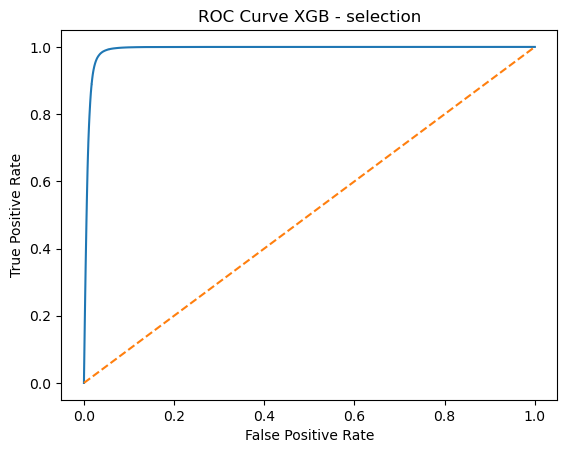

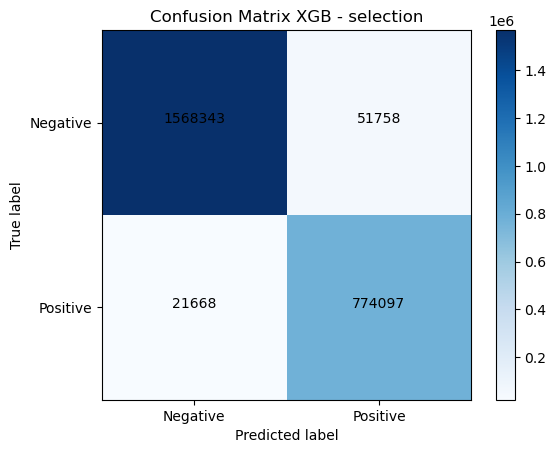

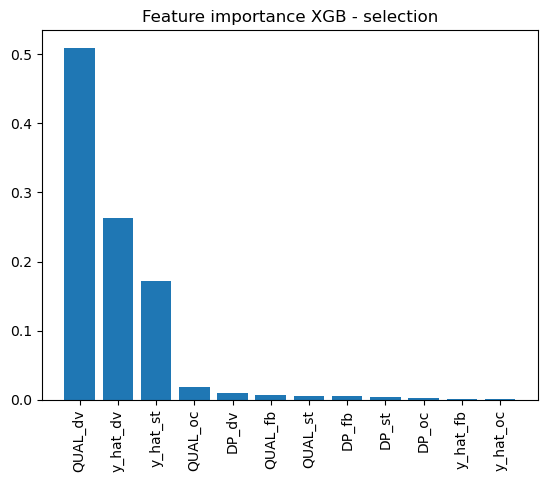

Training RF model for selection data
Model saved as src/models/RF/RF.joblib
Predictions saved as src/models/RF/RF.csv


,accuracy,precision,recall,f1,roc_auc
RF,0.969715,0.93862,0.971595,0.954823,0.990275


Calculating performance metrics for ['RF']
Saved performance metrics to src/models/RF/performance.csv


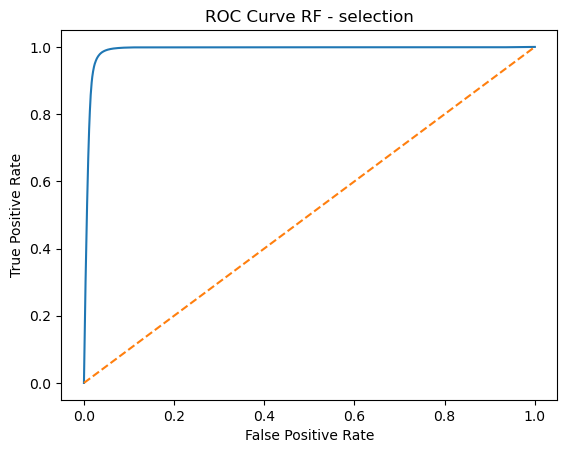

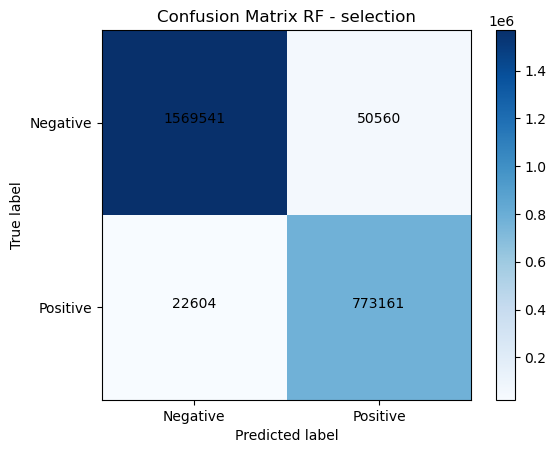

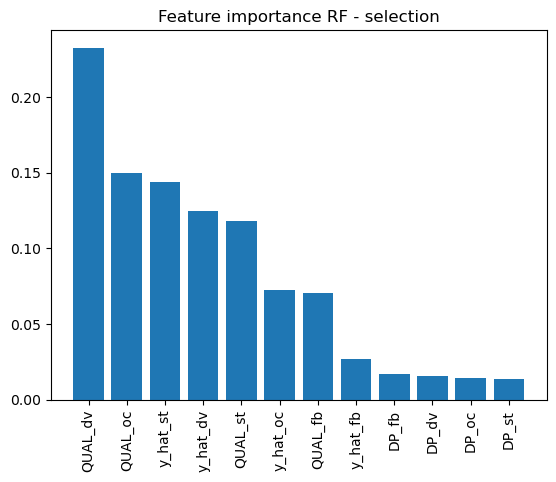

Training set
y
True     3048513
False    2680358
Name: count, dtype: int64
Test set
y
True     761638
False    670580
Name: count, dtype: int64
Selecting based on index: 1432218 / 7161089
Calculating performance metrics for ['dv']
Selecting based on index: 1432218 / 7161089
Calculating performance metrics for ['fb']
Selecting based on index: 1432218 / 7161089
Calculating performance metrics for ['oc']
Selecting based on index: 1432218 / 7161089
Calculating performance metrics for ['st']
Selecting based on index: 1432218 / 7161089
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 1432218 / 7161089
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 1432218 / 7161089
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Training XGB_confident model for selection_confident data
Model saved as src/models/XGB_confident/XGB_confident.joblib
Predictions saved as src/models/XGB_confident/XGB_confident.csv


,accuracy,precision,recall,f1,roc_auc
XGB_confident,0.99569,0.993652,0.998272,0.995957,0.998373


Calculating performance metrics for ['XGB']
Saved performance metrics to src/models/XGB_confident/performance.csv


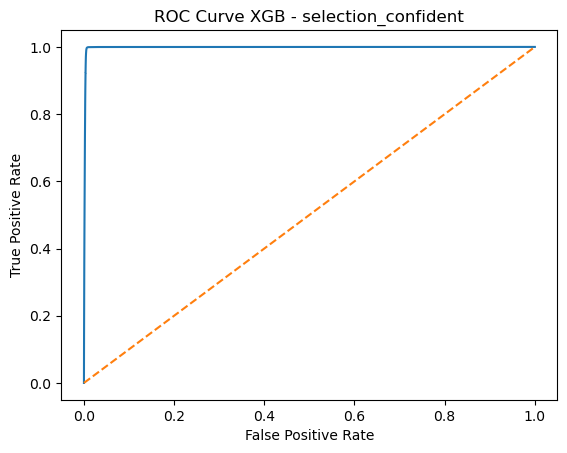

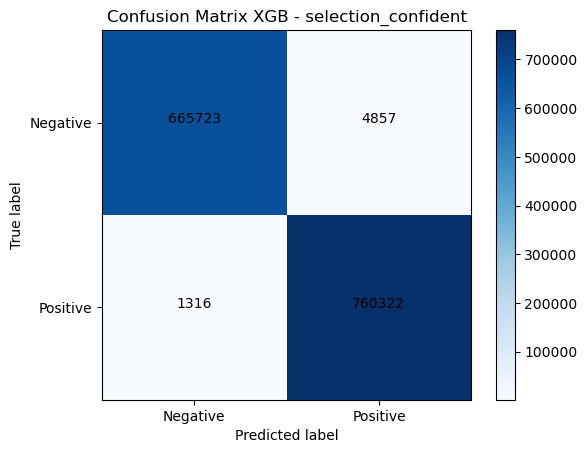

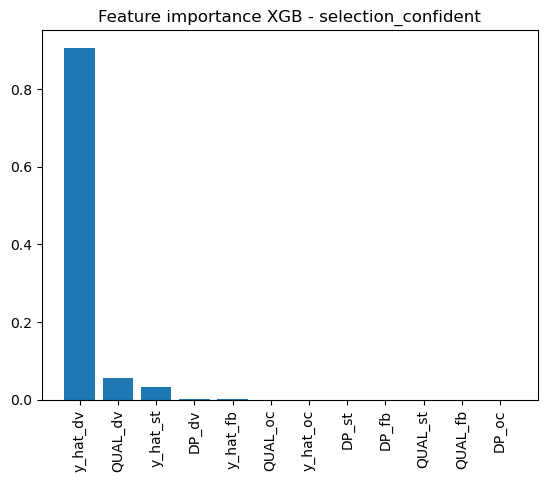

Training RF_confident model for selection_confident data
Model saved as src/models/RF_confident/RF_confident.joblib
Predictions saved as src/models/RF_confident/RF_confident.csv


,accuracy,precision,recall,f1,roc_auc
RF_confident,0.995783,0.993596,0.998506,0.996045,0.9979


Calculating performance metrics for ['RF']
Saved performance metrics to src/models/RF_confident/performance.csv


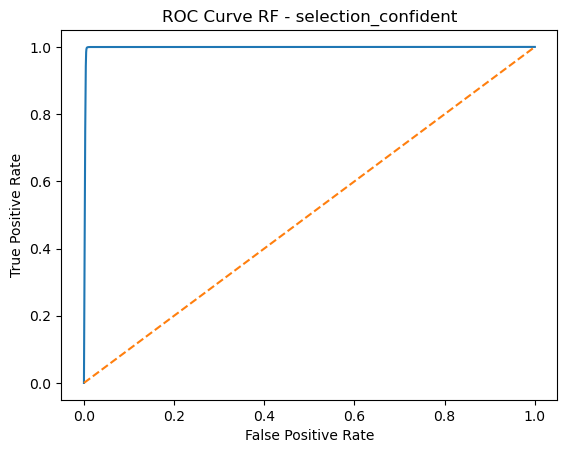

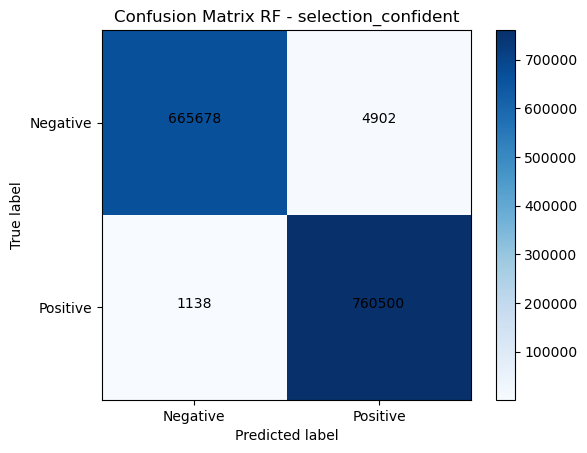

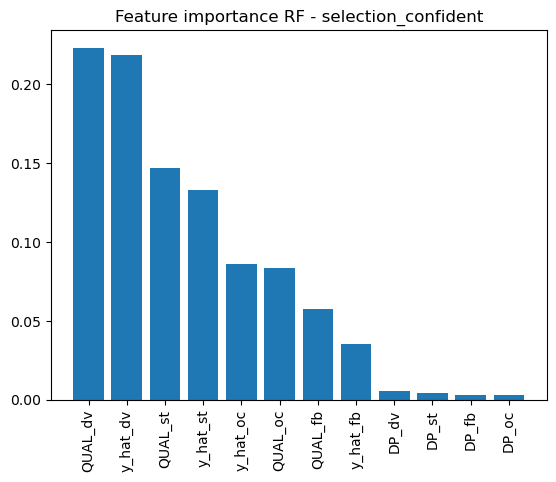

True-pos-baseline  \
DATA                CALLER         METHOD   METRICS                      
selection           dv             None     custom              795765   
                    fb             None     custom              795765   
                    oc             None     custom              795765   
                    st             None     custom              795765   
                    dv, fb, oc, st all      custom              795765   
                                   majority custom              795765   
                                   any      custom              795765   
                                   XGB      custom              795765   
                                   RF       custom              795765   
selection_confident dv             None     custom              761638   
                    fb             None     custom              761638   
                    oc             None     custom              761638   
                    st             None     custom              761638   
                    dv, fb, oc, st all      custom              761638   
                                   majority custom              761638   
                                   any      custom              761638   
                                   XGB      custom              761638   
                                   RF       custom              761638   

                                                     True-pos-call  False-pos  \
DATA                CALLER         METHOD   METRICS                             
selection           dv             None     custom          788784     141918   
                    fb             None     custom          769325     228299   
                    oc             None     custom          783932     142564   
                    st             None     custom          785230     119660   
                    dv, fb, oc, st all      custom          761903      72402   
                                   majority custom          785426     110515   
                                   any      custom          790877     290976   
                                   XGB      custom          774097      51758   
                                   RF       custom          773161      50560   
selection_confident dv             None     custom          756667       5005   
                    fb             None     custom          740766      20691   
                    oc             None     custom          753352      10128   
                    st             None     custom          754588       6302   
                    dv, fb, oc, st all      custom          735332       3910   
                                   majority custom          754933       5135   
                                   any      custom          757971      25584   
                                   XGB      custom          760322       4857   
                                   RF       custom          760500       4902   

                                                     False-neg  Precision  \
DATA                CALLER         METHOD   METRICS                         
selection           dv             None     custom        6981     0.8475   
                    fb             None     custom       26440     0.7712   
                    oc             None     custom       11833     0.8461   
                    st             None     custom       10535     0.8678   
                    dv, fb, oc, st all      custom       33862     0.9132   
                                   majority custom       10339     0.8766   
                                   any      custom        4888     0.7310   
                                   XGB      custom       21668     0.9373   
                                   RF       custom       22604     0.9386   
selection_confident dv             None     custom        4971     0.9934   
                    fb     

In [89]:
df_performance_all = run_model(clf_names=["XGB", "RF"])
df_performance_all

------------------------------------------------------------------------------------------------

## Nested Cross-validation

In [53]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import make_pipeline

RANDOM_STATE = 42

def model_gridCV(clf_names, param_grid, models):

    performance_dfs = []

    df_name = "merged_benchmark_confident"
    selection = "selection_confident"

    # data loading
    df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)

    X, y = get_X_y(df_VC_BM, callers=CALLERS)

    # get summary of performance metrics
    df_performance = create_performance_table(df_name, experiment = None, index=X.index) # No selection of data
    performance_dfs.append(df_performance)

    NUM_OUTER_FOLDS = 5
    NUM_INNER_FOLDS = 3

    for clf_name in clf_names:

        outer_folds = StratifiedKFold(
            n_splits=NUM_OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE
        )

        clf_performance_dfs = []

        for outer_fold, (train_ix, test_ix) in enumerate(outer_folds.split(X, y)):
            print(f"Outer fold {outer_fold}")

            X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
            y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

            X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

            inner_folds = StratifiedKFold(
                n_splits=NUM_INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE
            )

            clf_name_data = (
                clf_name + "_confident" if "confident" in selection else clf_name
            )

            # Create a folder for the model
            if not os.path.exists(f"src/models_gridCV/{clf_name_data}/outer_{outer_fold}"):
                os.makedirs(
                    f"src/models_gridCV/{clf_name_data}/outer_{outer_fold}", exist_ok=True
                )

            dir = f"src/models_gridCV/{clf_name_data}/outer_{outer_fold}"

            model_path = f"{os.path.join(dir, clf_name_data)}.joblib"
            if os.path.exists(model_path):
                print(f"Model {clf_name_data} already exists")
                clf = joblib.load(model_path)

            else:
                print(f"Training {clf_name_data} model for {selection} data")
                # make a pipeline
                search = make_pipeline(
                    PreprocessData(callers=CALLERS),
                    GridSearchCV(
                        estimator = models[clf_name],
                        param_grid = param_grid[clf_name],
                        cv=inner_folds,
                        scoring= ["f1", "recall", "precision"],
                        n_jobs=2,
                        verbose=1,
                        refit="f1",
                    ),
                )

                search.fit(X_train, y_train)
                clf = search.steps[1][1].best_estimator_
                params = search.steps[1][1].best_params_
                train_score = search.steps[1][1].best_score_

                print("Best parameters:", params)
                print(f"Training score: {train_score}")
                joblib.dump(clf, model_path)

            y_pred, y_pred_proba = evaluate_model(clf, X_test_scaled, clf_name_data, dir)

            df_call_model = pd.DataFrame({"y": y_test, "y_hat": y_pred}, index=X_test.index)
            performance = calculate_performance(
                df_call_model, callers=[clf_name], dir_path=dir
            )

            callers_str = ", ".join(CALLERS)
            multi_id = pd.MultiIndex.from_tuples(
                [(selection + f"_outer_{outer_fold}", callers_str, clf_name, "custom")],
                names=["DATA", "CALLER", "METHOD", "METRICS"],
            )
            df_performance_model = pd.DataFrame(performance, index=multi_id)

            clf_performance_dfs.append(df_performance_model)
            plot_feature_importance(clf, X_train_scaled, clf_name, selection + f" outer_{outer_fold}")

        clf_performance = pd.concat(clf_performance_dfs)
        display(clf_performance)

        # add the mean and std of the performance metrics
        metric_names = ["Precision", "Sensitivity", "F-measure"]
        avg = round(clf_performance[metric_names].mean(), 4)
        std = round(clf_performance[metric_names].std(), 4)
        clf_performance.loc[
            (f"{selection}_outer_mean", callers_str, clf_name, "custom"), metric_names
        ] = avg
        clf_performance.loc[
            (f"{selection}_outer_std", callers_str, clf_name, "custom"), metric_names
        ] = std

        display(clf_performance)

        performance_dfs.append(clf_performance)

    df_performance_all = pd.concat(performance_dfs)
    return df_performance_all

In [54]:
clf_names = ["XGB", "RF"]

# Set up possible values of parameters to optimize over
param_grid = {
    "RF": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 7, 11],
        "max_features": ["auto", "sqrt", "log2"],
    },
    "XGB": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 7, 11],
        "learning_rate": [0.01, 0.1, 0.2],
    },
}

# Create a dictionary with the models
models = {
    "RF": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGB": xgb.XGBClassifier(
        verbosity=2,
        nthread=8,
        eval_metric="aucpr",
        objective="binary:logistic",
        random_state=RANDOM_STATE,
    ),
}

df_performance_all = model_gridCV(clf_names, param_grid, models)

Selecting based on index: 7161089 / 7161089
Calculating performance metrics for ['dv']
Selecting based on index: 7161089 / 7161089
Calculating performance metrics for ['fb']
Selecting based on index: 7161089 / 7161089
Calculating performance metrics for ['oc']
Selecting based on index: 7161089 / 7161089
Calculating performance metrics for ['st']
Selecting based on index: 7161089 / 7161089
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 7161089 / 7161089
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 7161089 / 7161089
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Outer fold 0


Outer fold 0
Training XGB_confident model for selection_confident data
Model XGB_confident already exists
Predictions XGB_confident already exist
Calculating performance metrics for ['XGB']
Saved performance metrics to src/models_CV/XGB_confident/outer_0/performance.csv


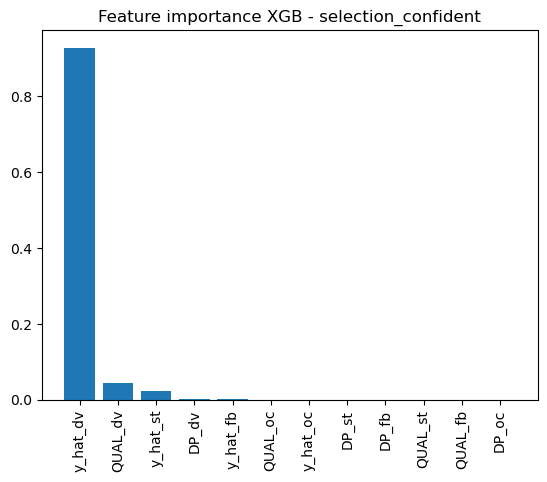

Outer fold 1
Training XGB_confident model for selection_confident data
Model XGB_confident already exists
Predictions XGB_confident already exist
Calculating performance metrics for ['XGB']
Saved performance metrics to src/models_CV/XGB_confident/outer_1/performance.csv


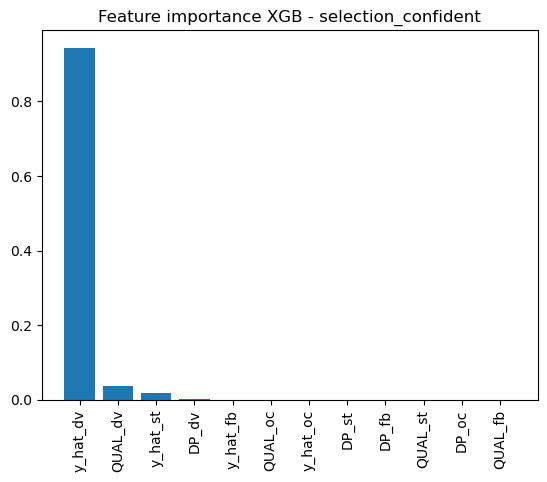

Outer fold 2
Training XGB_confident model for selection_confident data
Model XGB_confident already exists
Predictions XGB_confident already exist
Calculating performance metrics for ['XGB']
Saved performance metrics to src/models_CV/XGB_confident/outer_2/performance.csv


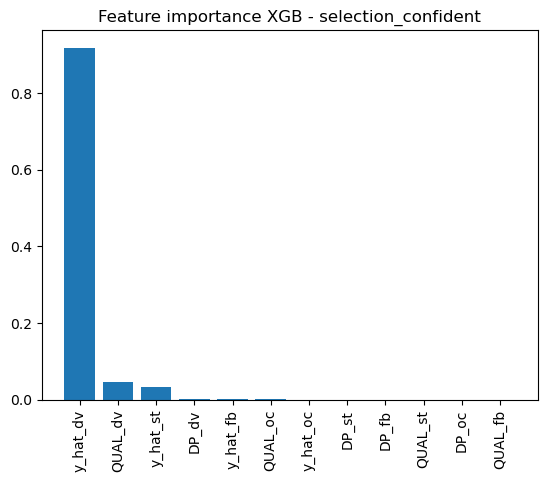

Outer fold 3
Training XGB_confident model for selection_confident data
Model XGB_confident already exists
Predictions XGB_confident already exist
Calculating performance metrics for ['XGB']
Saved performance metrics to src/models_CV/XGB_confident/outer_3/performance.csv


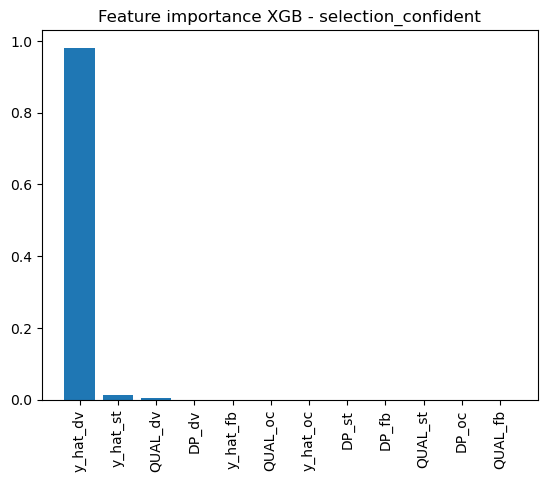

Outer fold 4
Training XGB_confident model for selection_confident data
Model XGB_confident already exists
Predictions XGB_confident already exist
Calculating performance metrics for ['XGB']
Saved performance metrics to src/models_CV/XGB_confident/outer_4/performance.csv


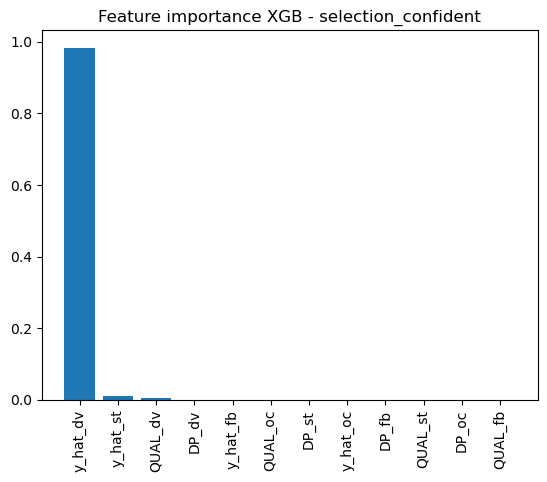

,,,,True-pos-baseline,True-pos-call,False-pos,False-neg,Precision,Sensitivity,F-measure
DATA,CALLER,METHOD,METRICS,,,,,,,
selection_confident_outer_0,"dv, fb, oc, st",XGB,custom,761638.0,760349.0,4896.0,1289.0,0.9936,0.9983,0.9959
selection_confident_outer_1,"dv, fb, oc, st",XGB,custom,762072.0,760757.0,4666.0,1315.0,0.9939,0.9983,0.9961
selection_confident_outer_2,"dv, fb, oc, st",XGB,custom,761857.0,760560.0,4817.0,1297.0,0.9937,0.9983,0.9960
selection_confident_outer_3,"dv, fb, oc, st",XGB,custom,762405.0,761104.0,4944.0,1301.0,0.9935,0.9983,0.9959
selection_confident_outer_4,"dv, fb, oc, st",XGB,custom,762179.0,760888.0,4790.0,1291.0,0.9937,0.9983,0.9960
selection_confident_outer_mean,"dv, fb, oc, st",XGB,custom,NaN,NaN,NaN,NaN,0.9937,0.9983,0.9960
selection_confident_outer_std,"dv, fb, oc, st",XGB,custom,NaN,NaN,NaN,NaN,0.0001,0.0000,0.0001


In [99]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import make_pipeline

clf_names = ["XGB"]

RANDOM_STATE = 42

# Set up possible values of parameters to optimize over
param_grid = {
    "RF": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7, 9, 11, 13],
        "max_features": ["auto", "sqrt", "log2"],
    },
    "XGB": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7, 9, 11, 13],
        "learning_rate": [0.01, 0.1, 0.2],
    },
}

# Create a dictionary with the models
models = {
    "RF": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGB": xgb.XGBClassifier(
        verbosity=2,
        nthread=8,
        eval_metric="aucpr",
        objective="binary:logistic",
        random_state=RANDOM_STATE,
    ),
}

performance_dfs = []

df_name = "merged_benchmark_confident"
selection = "selection_confident"

# data loading
df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)

# get summary of performance metrics
# df_performance = create_performance_table(df_name, experiment = None, index=None) # No selection of data

# performance_dfs.append(df_performance_test)

X, y = get_X_y(df_VC_BM, callers=CALLERS)

NUM_OUTER_FOLDS = 5

for clf_name in clf_names:

    outer_folds = KFold(
        n_splits=NUM_OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE
    )

    clf_performance_dfs = []

    for outer_fold, (train_ix, test_ix) in enumerate(outer_folds.split(X)):
        print(f"Outer fold {outer_fold}")

        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

        clf_name_data = (
            clf_name + "_confident" if "confident" in selection else clf_name
        )

        print(f"Training {clf_name_data} model for {selection} data")

        # Create a folder for the model
        if not os.path.exists(f"src/models_CV/{clf_name_data}/outer_{outer_fold}"):
            os.makedirs(
                f"src/models_CV/{clf_name_data}/outer_{outer_fold}", exist_ok=True
            )

        dir = f"src/models_CV/{clf_name_data}/outer_{outer_fold}"

        clf = train_model(X_train_scaled, y_train, clf_name_data, dir)
        y_pred, y_pred_proba = evaluate_model(clf, X_test_scaled, clf_name_data, dir)
        # metrics = calculate_metrics(y_test, y_pred, y_pred_proba, clf_name_data, dir)

        # display(metrics)

        df_call_model = pd.DataFrame({"y": y_test, "y_hat": y_pred}, index=X_test.index)
        performance = calculate_performance(
            df_call_model, callers=[clf_name], dir_path=dir
        )

        callers_str = ", ".join(CALLERS)
        multi_id = pd.MultiIndex.from_tuples(
            [(selection + f"_outer_{outer_fold}", callers_str, clf_name, "custom")],
            names=["DATA", "CALLER", "METHOD", "METRICS"],
        )
        df_performance_model = pd.DataFrame(performance, index=multi_id)

        clf_performance_dfs.append(df_performance_model)
        plot_feature_importance(clf, X_train_scaled, clf_name, selection)

    clf_performance = pd.concat(clf_performance_dfs)
    # display(clf_performance)

    # add the mean and std of the performance metrics
    metric_names = ["Precision", "Sensitivity", "F-measure"]
    avg = round(clf_performance[metric_names].mean(), 4)
    std = round(clf_performance[metric_names].std(), 4)
    clf_performance.loc[
        (f"{selection}_outer_mean", callers_str, clf_name, "custom"), metric_names
    ] = avg
    clf_performance.loc[
        (f"{selection}_outer_std", callers_str, clf_name, "custom"), metric_names
    ] = std
    display(clf_performance)

# Error analysis

## Type of errors

In [ ]:
import gzip


# load the TP, FP, FN, TN indices from the vcfeval results
def load_vcfeval_lists(experiment: str, DIR_VCFEVAL: str, callers=CALLERS) -> dict:

    list_of_dfs = []

    for caller in CALLERS:
        for l in ["tp", "fn", "fp"]:
            file_name = f"{DIR_VCFEVAL}/vcfeval_{caller}_{experiment}/{l}.vcf.gz"
            df = read_vcf(file_name)[["CHROM", "POS", "REF", "ALT"]]
            df["CALLER"] = caller
            df.set_index(["CHROM", "POS", "CALLER"], inplace=True)
            df["prediction"] = l.upper()

            # check if indels or snvs
            indels_bool = df["REF"].str.len() != df["ALT"].str.len()
            snvs_bool = ~indels_bool
            df["variant"] = None
            df.loc[indels_bool, "variant"] = "indel"
            df.loc[snvs_bool, "variant"] = "snv"

            list_of_dfs.append(df)

    df_vcfeval = pd.concat(list_of_dfs)

    return df_vcfeval


# INDELS vs SNVs
def get_indels(df_VC_BM, conf=CONF, callers=[CALLERS[0]]):

    how = "per_caller"
    features = ["REF", "ALT"]

    df_call = label_caller_data(
        df_VC_BM, conf, callers=callers, how=how, features=features
    )

    # label the indels and snvs
    indels_bool = (
        df_call[f"REF_{callers[0]}"].str.len() != df_call[f"ALT_{callers[0]}"].str.len()
    )
    snvs_bool = ~indels_bool

    df_call["variant"] = None
    df_call.loc[indels_bool, "variant"] = "indel"
    df_call.loc[snvs_bool, "variant"] = "snv"

    # label as TP, FP, FN, TN
    TP = df_call["y"] & df_call[f"y_hat_{callers[0]}"]
    FP = ~df_call["y"] & df_call[f"y_hat_{callers[0]}"]
    FN = df_call["y"] & ~df_call[f"y_hat_{callers[0]}"]
    TN = ~df_call["y"] & ~df_call[f"y_hat_{callers[0]}"]

    # save the indices of the indels and snvs, and the TP, FP, FN, TN
    indels = df_call[df_call["variant"] == "indel"].index
    snvs = df_call[df_call["variant"] == "snv"].index

    TP_index = df_call[TP].index
    FP_index = df_call[FP].index
    FN_index = df_call[FN].index
    TN_index = df_call[TN].index

    errors = {
        "TP": TP_index,
        "FP": FP_index,
        "FN": FN_index,
        "TN": TN_index,
        "indels": indels,
        "snvs": snvs,
    }

    df_call["prediction"] = None
    df_call.loc[TP, "prediction"] = "TP"
    df_call.loc[FP, "prediction"] = "FP"
    df_call.loc[FN, "prediction"] = "FN"
    df_call.loc[TN, "prediction"] = "TN"

    # show value counts, also in percentage
    print(df_call[["prediction", "variant"]].value_counts())

    return df_call

In [ ]:
df_vcfeval = load_vcfeval_lists("noinconsistent_withoutseq_qual", DIR_VCFEVAL)
df_vcfeval

REF ALT prediction variant
CHROM POS       CALLER                           
1     631859    dv      CG   C         TP   indel
      779047    dv       G   A         TP     snv
      779968    dv       T   G         TP     snv
      783006    dv       A   G         TP     snv
      783175    dv       T   C         TP     snv
...                     ..  ..        ...     ...
9     136139672 st      CA   C         FP   indel
      136501450 st       G  GA         FP   indel
      137201544 st      CA   C         FP   indel
      137265387 st      CT   C         FP   indel
      137717605 st       C  CA         FP   indel

[15404018 rows x 4 columns]

In [ ]:
for caller in CALLERS:
    print(f"Number of TP, FP, FN, TN for {caller}")
    display(
        df_vcfeval.loc[(slice(None), slice(None), caller), ["prediction", "variant"]]
        .value_counts()
        .sort_index(ascending=False)
    )

Number of TP, FP, FN, TN for dv


prediction  variant
TP          snv        3309188
            indel       497101
FP          snv           3701
            indel         1994
FN          snv          20860
            indel         5253
Name: count, dtype: int64

Number of TP, FP, FN, TN for fb


prediction  variant
TP          snv        3227063
            indel       479564
FP          snv          66166
            indel        19456
FN          snv          22052
            indel        30060
Name: count, dtype: int64

Number of TP, FP, FN, TN for oc


prediction  variant
TP          snv        3290595
            indel       535041
FP          snv          12915
            indel         3601
FN          snv          27849
            indel         6774
Name: count, dtype: int64

Number of TP, FP, FN, TN for st


prediction  variant
TP          snv        3304370
            indel       492878
FP          snv           7639
            indel         4018
FN          snv          28043
            indel         7837
Name: count, dtype: int64

In [ ]:
df_call = get_indels(df_merged_BM_confident)

prediction  variant
TP          snv        3293053
TN          snv        3066700
TP          indel       517107
TN          indel       217741
FP          snv          22373
FN          indel        18141
            snv           5465
FP          indel         2632
Name: count, dtype: int64


## Locating the errors on the chromosome

In [ ]:
from utils.utils import read_vcf

experiment = "noinconsistent_withoutseq_qual"
for l in ["tp", "fn", "fp"]:
    file_name = f"{DIR_VCFEVAL}/vcfeval_dv_{experiment}/{l}.vcf.gz"
    t = read_vcf(file_name)

    # save to bed file: #chr \t start \t end
    t_bed = t[["CHROM", "POS"]].copy()
    t_bed["END"] = t_bed["POS"]

    t_bed["CHROM"] = "chr" + t_bed["CHROM"].astype(str)

    t_bed.to_csv(
        f"{PATH_PROCESSED}/vcfeval_dv_{experiment}_{l}.bed",
        sep="\t",
        header=True,
        index=False,
    )

In [ ]:
t

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG003_NA24149_Ashkenazim_father.trim
0,1,632644,.,A,G,20.3,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:20:49:32,17:0.346939:20,0,39"
1,1,633182,.,A,G,37.4,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:37:63:24,39:0.619048:37,0,52"
2,1,633209,.,T,C,23.9,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:24:57:22,35:0.614035:23,0,48"
3,1,633230,.,C,T,11.5,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:11:58:21,37:0.637931:11,0,47"
4,1,633251,.,C,T,11.6,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:12:57:19,38:0.666667:11,0,43"
...,...,...,...,...,...,...,...,...,...,...
5690,9,135419782,.,G,GGTTTTGTTTT,13.1,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:13:58:40,13:0.224138:12,0,39"
5691,9,135419803,.,TG,T,22.1,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:22:49:33,13:0.265306:22,0,46"
5692,9,135632666,.,ATT,A,43.6,PASS,.,GT:GQ:DP:AD:VAF:PL,"1/1:22:70:2,49:0.7:43,21,0"
5693,9,135781639,.,T,TAA,36.4,PASS,.,GT:GQ:DP:AD:VAF:PL,"1/1:3:56:12,37:0.660714:33,0,0"


In [ ]:
import karyopype.karyopype as kp

experiment = "noinconsistent_withoutseq_qual"
l = "tp"

reg = pd.read_csv(f"{PATH_PROCESSED}/vcfeval_dv_{experiment}_{l}.bed", sep="\t")

# plot two sets of regions
kp.plot_karyopype("hg38", regions=[reg])

ImportError: cannot import name 'BrokenBarHCollection' from 'matplotlib.collections' (/Users/maartenbiolizard/mambaforge/envs/icr-variant_prediction/lib/python3.11/site-packages/matplotlib/collections.py)

In [ ]:
%pip install karyopype

Note: you may need to restart the kernel to use updated packages.


In [ ]:
df_call = get_indels(df_merged_BM)

prediction  variant
TN          snv        6394365
TP          snv        3389596
TN          indel       739289
TP          indel       582637
FP          snv         413559
            indel       319383
FN          indel        25082
            snv           7886
Name: count, dtype: int64


In [ ]:
df_call

y_hat_dv      y REF_dv ALT_dv  indel    snv
CHROM POS                                                   
1     10120         False  False      T      C  False   True
      10126         False  False      T      C  False   True
      10132         False  False      T      C  False   True
      10138         False  False      T      C  False   True
      10146         False  False     AC      A   True  False
...                   ...    ...    ...    ...    ...    ...
9     138309970     False  False      T      G  False   True
      138309972     False  False      T      G  False   True
      138314183     False  False      T      C  False   True
      138315559     False  False      G      A  False   True
      138319163     False  False      T      G  False   True

[11871797 rows x 6 columns]

In [ ]:
df_call.dropna(subset=["REF_BM", "ALT_BM"])

y_hat_dv     y REF_dv ALT_dv REF_BM ALT_BM
CHROM POS                                                  
1     602439        False  True    NaN    NaN      C      T
      602493        False  True    NaN    NaN      C      T
      602494        False  True    NaN    NaN      A      G
      631859         True  True     CG      C     CG      C
      779047         True  True      G      A      G      A
...                   ...   ...    ...    ...    ...    ...
9     138161156      True  True      G      A      G      A
      138163972      True  True      T      G      T      G
      138199834      True  True      C      G      C      G
      138201367      True  True      C      T      C      T
      138202773      True  True      A      G      A      G

[4031125 rows x 6 columns]